In [11]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split

In [2]:
class Net(nn.Module):
    def __init__(self,input_size):
        super(Net, self).__init__()
            
        ##ONE HIDDEN LAYER
        self.fc1 = nn.Linear(input_size,int(input_size/10.0))
        self.fc2 = nn.Linear(int(input_size/10.0),1)
        
        #TWO HIDDEN LAYERS
        #self.fc1 = nn.Linear(input_size,int(input_size/4.0))
        #self.fc2 = nn.Linear(int(input_size/4.0),int(input_size/8.0))
        #self.fc3 = nn.Linear(int(input_size/8.0),1)
        
        
    def forward(self, obs):
        #NO HIDDEN LAYER
        #x = self.fc1(x)

        #ONE HIDDEN LAYER
        #x = torch.sigmoid(self.fc1(obs))
        x = F.relu(self.fc1(obs))
        x = self.fc2(x)

        #TWO HIDDEN LAYERS
        #x = F.relu(self.fc1(obs))
        #x = F.relu(self.fc2(x))
        #x = self.fc3(x)
        
        return x
        


class SciNet(nn.Module):
    def __init__(self,input_dim, output_dim, latent_dim, layer_dim):
        super(Net, self).__init__()
        
        #NO HIDDEN LAYER
        #self.fc1 = nn.Linear(input_size,1)
        
        #ONE HIDDEN LAYER
        self.fc1 = nn.Linear(input_size,int(input_size/8.0))
        self.fc2 = nn.Linear(int(input_size/8.0),1)
        
        #TWO HIDDEN LAYERS
        #self.fc1 = nn.Linear(input_size,int(input_size/3.0))
        #self.fc2 = nn.Linear(int(input_size/3.0), int(input_size/4.0))
        #self.fc3 = nn.Linear(int(input_size/4.0), 1)
        
        #SCINET
        #super(SciNet, self).__init__()
        #self.latent_dim = latent_dim
        #self.enc1 = nn.Linear(input_dim, layer_dim)
        #self.enc2 = nn.Linear(layer_dim, layer_dim)
        #self.latent = nn.Linear(layer_dim, latent_dim*2)
        #self.dec1 = nn.Linear(latent_dim+1, layer_dim)
        #self.dec2 = nn.Linear(layer_dim, layer_dim)
        #self.out = nn.Linear(layer_dim, output_dim)
        
    def encoder(self, x):
        z = F.elu(self.enc1(x))
        z = F.elu(self.enc2(z))
        z = self.latent(z)
        
        self.mu = z[:, 0:self.latent_dim]
        self.log_sigma = z[:, self.latent_dim]
        self.sigma = torch.exp(self.log_sigma)
        
        eps = torch.randn(x.size(0), self.latent_dim)
        z_sample = self.mu + self.sigma + eps
        
        self.k1_loss = k1_divergence(self.mu, self.log_sigma, dim=self.latent_dim)
        
        return z_sample
    
    def decoder(self,z):
        x = F.elu(self.dec1(z))
        x = F.elu(self.dec2(x))
        return self.out(x) 

    def forward(self, obs):
        #NO HIDDEN LAYER
        #x = self.fc1(x)

        #ONE HIDDEN LAYER
        x = torch.sigmoid(self.fc1(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        #TWO HIDDEN LAYERS
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = self.fc3(x)
        
        #SCINET Forward
        #q = obs[:,-1].reshape(obs.size(0),1)
        #obs = obs[:,0:-1]
        #self.latent_r = self.encoder(obs)
        #dec_input = torch.cat( (q, self.latent_r),1)
        
        return self.decoder(dec_input)
    
def k1_divergence(means, log_sigma, dim, target_sigma=0.1):
    target_sigma = torch.Tensor([target_sigma])
    return 1/2. * torch.mean(torch.mean(1/ target_sigma**2 * means**2 + 
            torch.exp(2* log_sigma) / target_sigma**2 - 2 * log_sigma + 2 * torch.log(target_sigma), dim=1) - dim)

In [3]:
def main():
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    #test_input = [np.random.randn(100,1),np.random.randn(100,1),np.random.randn(100,1),np.random.randn(100,1)]
    #test_y     = [np.random.randn(1,1),np.random.randn(1,1),np.random.randn(1,1),np.random.randn(1,1)]
    
    #test_input = np.random.randn(50,100).astype(np.float32)
    #test_y     = np.random.randn(50,1).astype(np.float32)
    
    #test_input = np.load("DATA/X_features.nparray.npy").astype(np.float32)
    #test_y = np.loadtxt("DATA/AQ_AQ-_VEE.dat").astype(np.float32)
    #test_y = np.reshape(test_y,(len(test),1))
    
    #x_tensor = torch.from_numpy(test_input).float()
    #y_tensor = torch.from_numpy(test_y).float()

    npX_train = np.load("DATA/X_train.npy").astype(np.float32)
    npX_val   = np.load("DATA/X_val.npy").astype(np.float32)
    npy_train = np.load("DATA/y_train.npy").astype(np.float32)
    npy_val   = np.load("DATA/y_val.npy").astype(np.float32)
    #feature_normalization = np.load("DATA/feature_normalization.npy")
    
    
    class CustomDataset(Dataset):
        def __init__(self, x_tensor, y_tensor):
            self.x = x_tensor
            self.y = y_tensor

        def __getitem__(self, index):
            return (self.x[index], self.y[index])

        def __len__(self):
            return np.shape(x)[1]
    
    #X_tensor = torch.stack([torch.from_numpy(np.array(i)) for i in test_input])
    #y_tensor = torch.stack([torch.from_numpy(np.array(i)) for i in test_y])
    
    
    #Define split of data (80% train: 20% validation)
    #train_size = int(0.8*np.shape(test_input)[0])
    train_size = int(0.80*500.0)
    
    #Define training and validation sets
    #X_train = X_tensor[:train_size]
    #y_train = y_tensor[:train_size]
    #X_val = X_tensor[train_size:]
    #y_val = y_tensor[train_size:]
    X_train = torch.stack([torch.from_numpy(np.array(i)) for i in npX_train])
    y_train = torch.stack([torch.from_numpy(np.array(i)) for i in npy_train])
    X_val = torch.stack([torch.from_numpy(np.array(i)) for i in npX_val])
    y_val = torch.stack([torch.from_numpy(np.array(i)) for i in npy_val])
    
    print(np.shape(npX_train),np.shape(npy_train),np.shape(npX_val),np.shape(npy_val))
    
    train_dataset  = TensorDataset(X_train,y_train)
    train_loader   = DataLoader(dataset=train_dataset, batch_size=500)
    
    val_dataset    = TensorDataset(X_val,y_val)
    val_loader     = DataLoader(dataset=val_dataset, batch_size=500)
    
    
    #train_dataset, val_dataset = random_split(dataset, [int(len(test_input)*0.8),len(test_input)-int(len(test_input)*0.8)])
    
    
    def make_train_step(model, loss_fn, optimizer):
        def train_step(x, y):
            model.train()
            yhat = model(x)
            loss = loss_fn(y, yhat)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            return loss.item()
        return train_step
        
        
    #DEFINE MODEL AND PARAMETERS  (self,input_dim, output_dim, latent_dim, layer_dim)
    model = Net(np.shape(npX_train)[1]).to(device)
    loss_fn = nn.MSELoss(reduction='mean')
    #loss_fn =nn.SmoothL1Loss(reduction='mean')
    #optimizer = optim.Adamax(model.parameters(), lr=1e-4, weight_decay=0.075)
    #optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.75)
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.8,weight_decay=0.001)
    train_step = make_train_step(model, loss_fn, optimizer)
    
    n_epochs = 300
    training_losses = []
    validation_losses = []
    #print(model.state_dict())
    
    for epoch in range(n_epochs):
        batch_losses = []
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            loss = train_step(x_batch, y_batch)
            batch_losses.append(loss)
        training_loss = np.mean(batch_losses)
        training_losses.append(training_loss)

        with torch.no_grad():
            val_losses = []
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                model.eval()
                yhat = model(x_val)
                val_loss = loss_fn(y_val, yhat).item()
                val_losses.append(val_loss)
            validation_loss = np.mean(val_losses)
            validation_losses.append(validation_loss)

        print(f"[{epoch+1}] Training loss: {training_loss:.3f}\t Validation loss: {validation_loss:.3f}")

    return model


In [4]:
if __name__ == '__main__':
    trained_model = main()

(399, 417) (399, 1) (100, 417) (100, 1)
[1] Training loss: 0.184	 Validation loss: 0.164
[2] Training loss: 0.180	 Validation loss: 0.156
[3] Training loss: 0.172	 Validation loss: 0.147
[4] Training loss: 0.162	 Validation loss: 0.136
[5] Training loss: 0.151	 Validation loss: 0.126
[6] Training loss: 0.139	 Validation loss: 0.115
[7] Training loss: 0.128	 Validation loss: 0.105
[8] Training loss: 0.117	 Validation loss: 0.096
[9] Training loss: 0.107	 Validation loss: 0.088
[10] Training loss: 0.098	 Validation loss: 0.081
[11] Training loss: 0.090	 Validation loss: 0.075
[12] Training loss: 0.083	 Validation loss: 0.070
[13] Training loss: 0.077	 Validation loss: 0.066
[14] Training loss: 0.072	 Validation loss: 0.063
[15] Training loss: 0.068	 Validation loss: 0.060
[16] Training loss: 0.064	 Validation loss: 0.058
[17] Training loss: 0.061	 Validation loss: 0.057
[18] Training loss: 0.059	 Validation loss: 0.055
[19] Training loss: 0.057	 Validation loss: 0.055
[20] Training loss:

[171] Training loss: 0.032	 Validation loss: 0.045
[172] Training loss: 0.032	 Validation loss: 0.045
[173] Training loss: 0.032	 Validation loss: 0.045
[174] Training loss: 0.032	 Validation loss: 0.044
[175] Training loss: 0.032	 Validation loss: 0.044
[176] Training loss: 0.032	 Validation loss: 0.044
[177] Training loss: 0.032	 Validation loss: 0.044
[178] Training loss: 0.032	 Validation loss: 0.044
[179] Training loss: 0.032	 Validation loss: 0.044
[180] Training loss: 0.032	 Validation loss: 0.044
[181] Training loss: 0.032	 Validation loss: 0.044
[182] Training loss: 0.032	 Validation loss: 0.044
[183] Training loss: 0.032	 Validation loss: 0.044
[184] Training loss: 0.031	 Validation loss: 0.044
[185] Training loss: 0.031	 Validation loss: 0.044
[186] Training loss: 0.031	 Validation loss: 0.044
[187] Training loss: 0.031	 Validation loss: 0.044
[188] Training loss: 0.031	 Validation loss: 0.044
[189] Training loss: 0.031	 Validation loss: 0.044
[190] Training loss: 0.031	 Val

In [5]:
test_input = np.load("DATA/TEST/X_test.npy").astype(np.float32)
print(np.shape(test_input))

(500, 417)


In [6]:
test_y = np.loadtxt("DATA/AQ_AQ-_VEE.dat").astype(np.float32)
test_y = np.reshape(test_y,(len(test),1))
print(np.shape(test_input),np.shape(test_y))

NameError: name 'test' is not defined

In [ ]:
np.shape(trained_model['fc1.weight'].numpy().T)

In [12]:
import numpy as np
from scipy.stats import norm
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

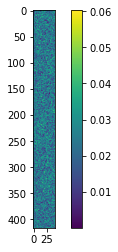

In [13]:
fc1_weights = trained_model.state_dict()['fc1.weight'].numpy().T
fc2_weights = trained_model.state_dict()['fc2.weight'].numpy().T
#fc3_weights = trained_model['fc3.weight'].numpy().T

fig, ax = plt.subplots()
im = ax.imshow(np.abs(fc1_weights[:,:]))

cbar = ax.figure.colorbar(im, ax=ax)


plt.show()


In [14]:
#Save Predictions for Gap for a given X_TEST (better for small numbers of frames)
trained_model.eval()
npX_test = np.load("DATA/TEST/X_test.npy").astype(np.float32)
X_test = torch.stack([torch.from_numpy(np.array(i)) for i in npX_test])

yhat = np.zeros((len(X_test),1))
with torch.no_grad():
    for i in range(len(X_test)):
        yhat[i] = trained_model(X_test[i,:])

print(yhat)

[[-2.22284213e-01]
 [-1.97913647e-01]
 [-1.71690136e-01]
 [-2.12140441e-01]
 [-2.73708701e-01]
 [-3.15382689e-01]
 [-2.78752357e-01]
 [-2.67019868e-01]
 [-2.40592152e-01]
 [-2.20269188e-01]
 [-2.20934585e-01]
 [-2.14671299e-01]
 [-2.06708223e-01]
 [-2.23612174e-01]
 [-2.90119886e-01]
 [-3.41745049e-01]
 [-3.66955519e-01]
 [-3.97879303e-01]
 [-4.56006378e-01]
 [-4.61204320e-01]
 [-4.08790410e-01]
 [-3.54699671e-01]
 [-2.99294293e-01]
 [-2.50796199e-01]
 [-2.12786004e-01]
 [-1.50712922e-01]
 [-1.13819830e-01]
 [-9.10542607e-02]
 [-3.62618342e-02]
 [-1.85688198e-01]
 [-2.31812641e-01]
 [-1.78188086e-01]
 [-1.97781235e-01]
 [-2.88755834e-01]
 [-3.38205397e-01]
 [-3.56170535e-01]
 [-3.34141970e-01]
 [-2.94511765e-01]
 [-1.92530483e-01]
 [-1.11419253e-01]
 [-2.18950361e-02]
 [ 1.47312284e-02]
 [-1.03230551e-02]
 [ 8.83247703e-03]
 [ 3.52440774e-02]
 [ 4.25908267e-02]
 [ 2.78522149e-02]
 [-3.62518430e-03]
 [-8.02921653e-02]
 [-2.03421652e-01]
 [-2.81022429e-01]
 [-3.49116921e-01]
 [-3.6538052

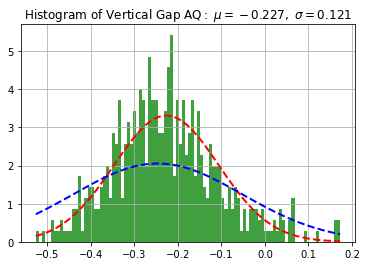

In [15]:
#Generate Marcus Curves
trained_model.eval()

npX_test = np.load("DATA/TEST/X_test.npy").astype(np.float32)
X_test = torch.stack([torch.from_numpy(np.array(i)) for i in npX_test])

yhat = np.zeros((len(X_test),1))

with torch.no_grad():
    for i in range(len(X_test)):
        yhat[i] = trained_model(X_test[i,:])

#print(yhat)

(mu, sigma) = norm.fit(yhat)

n, bins, patches = plt.hist(yhat, 100, density = 1, facecolor='green', alpha=0.75)

#Predicted from NN (N=1000)
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

#Predicted from Ab-Initio (N=500)
y2 = norm.pdf( bins, -0.24635, 0.19428)
l2 = plt.plot(bins, y2, 'b--', linewidth=2)

plt.grid(True)

plt.title(r'$\mathrm{Histogram\ of\ Vertical\ Gap\ AQ:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))

plt.show()
